In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits
import sys
import copy
%matplotlib inline

import os

os.environ["OMP_NUM_THREADS"] = "64" 

import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
plt.rcParams['image.cmap'] = 'coolwarm'

In [29]:
from NPTFit import create_mask as cm

In [64]:
import pysm3
import pysm3.units as u
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize

In [3]:
import time

In [4]:
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

In [5]:
import utilities
import imp
imp.reload(utilities)

<module 'utilities' from '/global/u2/j/jianyao/foreground_non_gaussianity/utilities.py'>

In [6]:
from utilities import *

In [7]:
output_nside = 2048 
output_lmax = 2 * output_nside
datadir="/global/cscratch1/sd/jianyao/Dust/"
savedir="/global/cscratch1/sd/jianyao/Dust/MFs/"

ss_cl = np.load('/global/cscratch1/sd/jianyao/Dust/small_scales_cl.npy')
ss_cl_pt = hp.read_cl('/global/cscratch1/sd/jianyao/Dust/small_scales_logpoltens_cl_lmax4096.fits')
ss_cl = np.row_stack((ss_cl, np.zeros(output_lmax + 1)))
ss_cl_pt = np.row_stack((ss_cl_pt, np.zeros(output_lmax + 1)))


lmax = 2048;nside = 2048;
comp = "IQU"
spectra_components = ["TT", "EE", "BB"]
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}

In [8]:
planck_mask_filename = "/global/cscratch1/sd/jianyao/Dust/" + "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
planck_mask_80 = hp.read_map(planck_mask_filename, ["GAL080"])

In [9]:
planck_mask_90 = hp.read_map(planck_mask_filename, ["GAL090"])

In [254]:
mask_50 = cm.make_mask_total(b_mask = True, b_deg_min = -30, b_deg_max = 30, nside = 2048)
mask_50 = mask_50*1
mask_50 = nmt.mask_apodization(mask_50, 2., apotype="C2")

In [255]:
mask_50.sum()/len(mask_50)

0.4851403000738803

In [90]:
dust_IQU = hp.read_map('/global/cscratch1/sd/jianyao/Dust/Dust_IQU_uK_RJ.fits', field = None) ### original maps in IQU
log_pol_tens_varres = hp.read_map('/global/cscratch1/sd/jianyao/Dust/dust_gnilc_logpoltens_varres_nomono.fits', field = None) ### original maps in iqu

In [91]:
ls = get_large_scales(dust_IQU, lmax, spectra_components, ell_fit_high, output_nside)
log_ls = get_large_scales(log_pol_tens_varres, lmax, spectra_components, ell_fit_high, output_nside)

In [92]:
my_modulate_amp = hp.read_map(datadir + f"My_modulate_amp_nside{nside}.fits")
my_modulate_amp_pol = hp.read_map(datadir + f"My_modulate_amp_pol_nside{nside}.fits")

modulate_amp = hp.read_map(datadir + f"modulate_amp_nside{nside}.fits")
modulate_amp_pol = hp.read_map(datadir + f"modulate_amp_pol_nside{nside}.fits")

In [93]:
log_ss = hp.synfast(ss_cl_pt, lmax=output_lmax, new=True,nside=output_nside) # maps generated from small iqu cls
ss = hp.synfast(ss_cl, lmax=output_lmax, new=True,nside=output_nside) #maps generated from IQU cls

/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


# modulate small scales

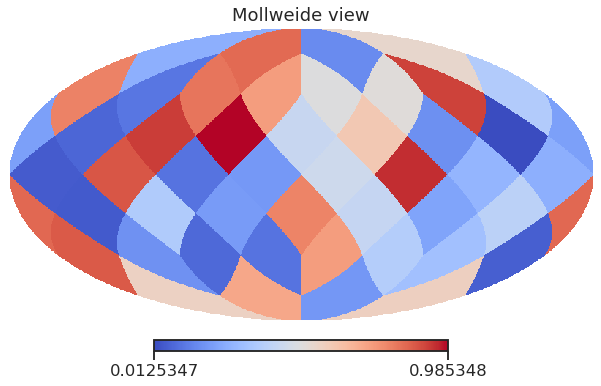

In [21]:
hp.mollview(np.random.rand(12*4))

In [15]:
new_mod = 0.0599*minmax(ls[0], 2, 6)**0.782

new_mod = hp.smoothing(new_mod, fwhm=np.radians(5), lmax=lmax)
new_mod = minmax(new_mod, 0, 6)

- A direction:

ismooth = hp.smoothing(dust_IQU[0], fwhm=np.radians(5), lmax=lmax)

new_mod = minmax(ismooth, 0, 8)

In [168]:
ismooth = hp.smoothing(dust_IQU[0], fwhm=np.radians(5), lmax=lmax)

In [264]:
# new_mod = 0.0599*new_mod**0.782
new_mod = minmax(ismooth, 0, 6)

In [74]:
# # new_mod = hp.smoothing(ls[0], fwhm=np.radians(5), lmax=lmax)
# new_mod = 0.00376*ls[0]**0.0777
# # new_mod = minmax(new_mod, 0, 6)

- second direction:

 saturating 

In [176]:
ismooth.max()

6174.201665132205

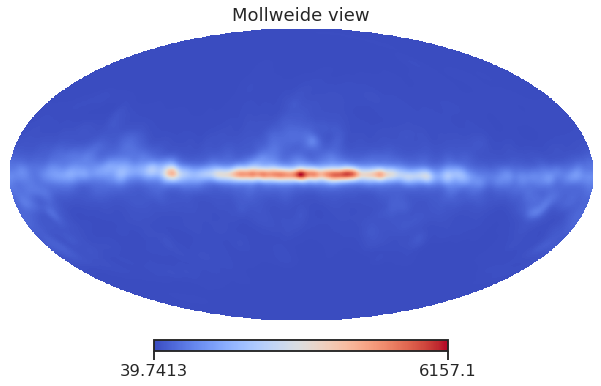

In [156]:
hp.mollview(ismooth)

In [413]:
b1 = 0.4
b2 = 11
a = 0.
val = 400
modulate_amp = (ismooth) * 1.0

mskmd = ismooth > val

modulate_amp[mskmd] = minmax(ismooth[mskmd], a=b1, b=b2)

modulate_amp[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

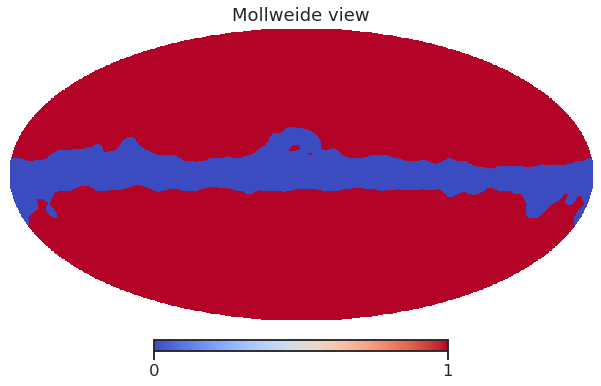

In [432]:
mask_mod = np.ones(len(ismooth))
mask_mod[mskmd] = 0
hp.mollview(mask_mod)

In [417]:
b3 = 0.65
b4 = 5
a2 = 0.0
val2 = 400
modulate_amp_pol = (ismooth) * 1.0
mskmd = ismooth > val2
modulate_amp_pol[mskmd] = minmax(ismooth[mskmd], a=b3, b=b4)
modulate_amp_pol[~mskmd] = minmax(ismooth[~mskmd], a=a2, b=b3)

In [248]:
ss_modulate = np.zeros_like(ss)
ss_modulate[0] =ss[0]*modulate_amp
ss_modulate[1:] = ss[1:]*modulate_amp_pol

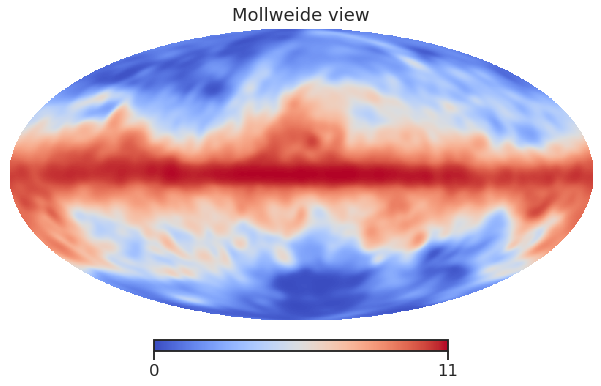

In [418]:
hp.mollview(modulate_amp_pol, norm = 'hist', min = 0, max = 11)

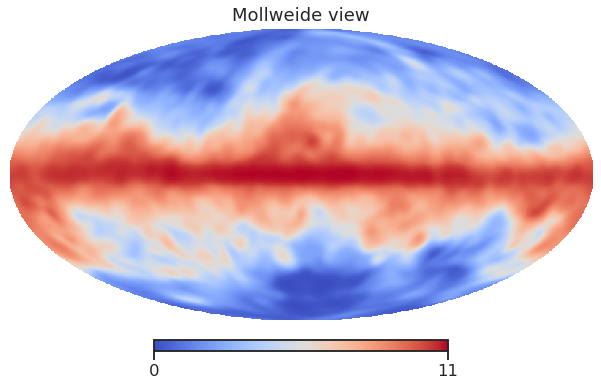

In [416]:
hp.mollview(modulate_amp, norm = 'hist', min = 0, max = 11)

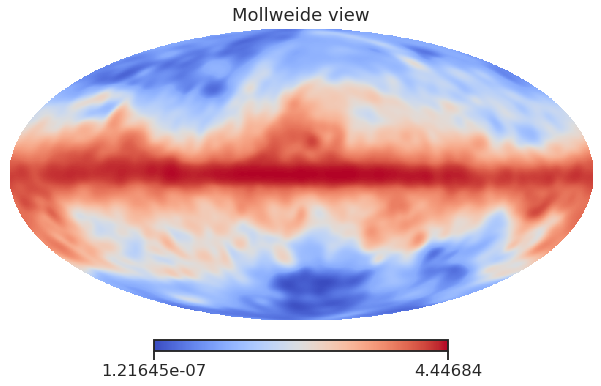

In [431]:
hp.mollview(modulate_amp - new_mod*1.09, norm = 'hist')

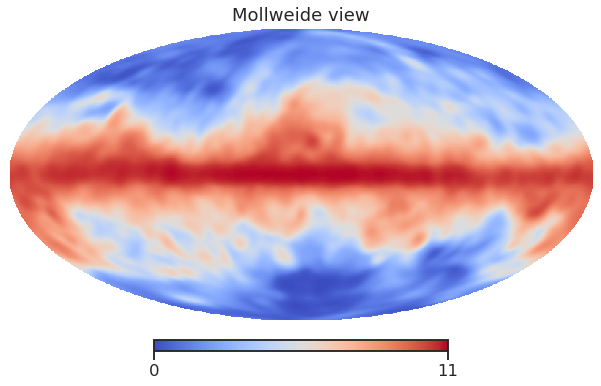

In [415]:
hp.mollview(new_mod, norm = 'hist', min = 0, max = 11)

In [399]:
lmax = 1000

# ell_hp, cl_norm_hp, cl_IQU_hp = run_anafast(dust_IQU, lmax = lmax)
# ell, cl_norm, cl_IQU_na = run_namaster(dust_IQU, mask=planck_mask_80, lmax=lmax, nlbins = 10)

# ell_hp, cl_norm_hp, cl_LS_hp = run_anafast(ls, lmax = lmax)

# ell, cl_norm, cl_LS_na = run_namaster(ls, mask=planck_mask_80, lmax=lmax, nlbins = 10)
# ell, cl_norm, cl_LS_na_90 = run_namaster(ls, mask=planck_mask_90, lmax=lmax, nlbins = 10)

# for i in range(3):
#     cl_LS_hp[modes[i]][np.where(cl_LS_hp[modes[i]] < 1e-10)] = 0;
#     cl_LS_na_90[modes[i]][np.where(cl_LS_na_90[modes[i]] < 1e-10)] = 0;
#     cl_LS_na[modes[i]][np.where(cl_LS_na[modes[i]] < 1e-10)] = 0;

In [ ]:
Map2 = ls + ss*new_mod*1.7065 # direction 1
Map2[0] = ls[0] + ss[0]*new_mod*1.0955 # direction 1

# Map2 = ls + ss*new_mod # direction 1
# Map2[0] = ls[0] + ss[0]*new_mod # direction 1

# Map2 = ls + ss*modulate_amp # see TT only, direction 2--saturating
# Map2 = ls + ss_modulate ## TT,EE and BB, saturating

ell_hp, cl_norm_hp, cl2_hp = run_anafast(Map2, lmax = lmax)

ell, cl_norm, cl2_na = run_namaster(Map2, mask=planck_mask_80, lmax=lmax, nlbins = 10)
ell, cl_norm, cl2_na_90 = run_namaster(Map2, mask=planck_mask_90, lmax=lmax, nlbins = 10)
# ell, cl_norm, cl2_na_50 = run_namaster(Map2, mask = mask_50, lmax=lmax, nlbins = 10)

<ipython-input-400-77006b9e0712>:14: RuntimeWarning: invalid value encountered in true_divide
  r1 = np.sqrt(np.mean((cl_IQU_iqu_na_90[modes[i]]/(cl2_na_90[modes[i]] - cl_LS_na_90[modes[i]]))[mask_start:]));
<ipython-input-400-77006b9e0712>:15: RuntimeWarning: invalid value encountered in true_divide
  r2 = np.sqrt(np.mean((cl_IQU_iqu_na[modes[i]]/(cl2_na[modes[i]] - cl_LS_na[modes[i]]))[mask_start:]));
<ipython-input-400-77006b9e0712>:13: RuntimeWarning: invalid value encountered in true_divide
  r0 = np.sqrt(np.mean((cl_IQU_iqu_hp[modes[i]]/(cl2_hp[modes[i]] - cl_LS_hp[modes[i]]))[full_start:]));
<ipython-input-400-77006b9e0712>:14: RuntimeWarning: invalid value encountered in true_divide
  r1 = np.sqrt(np.mean((cl_IQU_iqu_na_90[modes[i]]/(cl2_na_90[modes[i]] - cl_LS_na_90[modes[i]]))[mask_start:]));
<ipython-input-400-77006b9e0712>:15: RuntimeWarning: invalid value encountered in true_divide
  r2 = np.sqrt(np.mean((cl_IQU_iqu_na[modes[i]]/(cl2_na[modes[i]] - cl_LS_na[modes[i]]))[mas

Text(0.5, 0.98, 'Green: IQU; Red: IQU_iqu; 100%, 90%, 80%; Original Modulation')

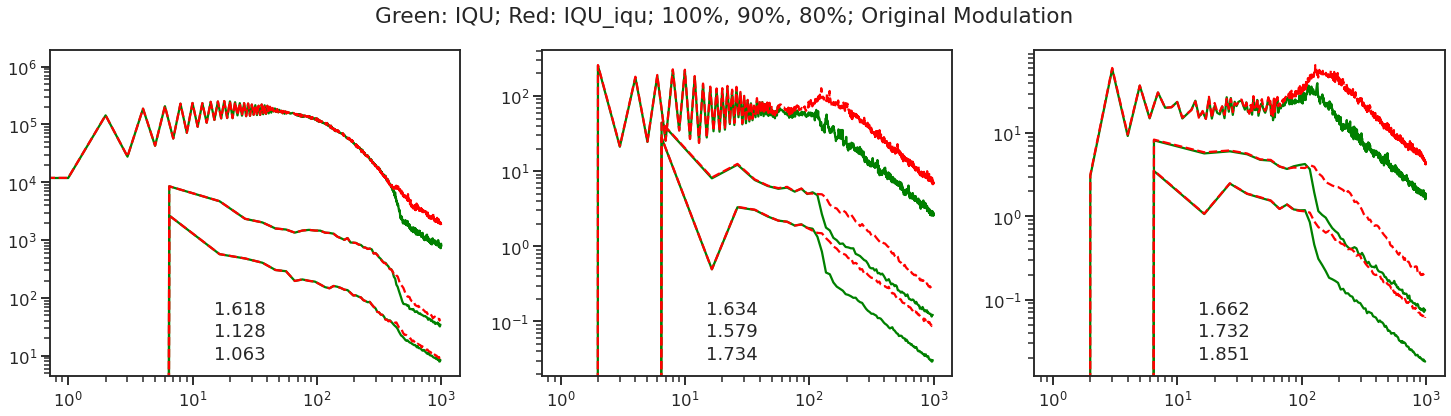

In [400]:
##### modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))

for i in range(3):
    ax = axes[i]
    start = 18
    if i == 0:
        full_start = 536 # for TT
        mask_start = 55  # ell[45] = 536.5
    else:
        full_start = int(ell[start]) # for EE and BB
        mask_start = start
    r0 = np.sqrt(np.mean((cl_IQU_iqu_hp[modes[i]]/(cl2_hp[modes[i]] - cl_LS_hp[modes[i]]))[full_start:]));    
    r1 = np.sqrt(np.mean((cl_IQU_iqu_na_90[modes[i]]/(cl2_na_90[modes[i]] - cl_LS_na_90[modes[i]]))[mask_start:]));
    r2 = np.sqrt(np.mean((cl_IQU_iqu_na[modes[i]]/(cl2_na[modes[i]] - cl_LS_na[modes[i]]))[mask_start:]));
                         
    ax.loglog(ell_hp,  cl_norm_hp*cl2_hp[modes[i]], 'g-', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl2_na_90[modes[i]], 'g-',label = '90%')
    ax.loglog(ell,  cl_norm*cl2_na[modes[i]], 'g-',label = '80%')
    plt.text(0.4, 0.19, '%0.3f'%r0, transform = ax.transAxes)
    plt.text(0.4, 0.12, '%0.3f'%r1, transform = ax.transAxes)
    plt.text(0.4, 0.05, '%0.3f'%r2, transform = ax.transAxes)
    
    # ax.loglog(ell,  cl_norm*cl_IQU_na[modes[i]], 'k--',label = '80%')
    
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_hp[modes[i]], 'r--', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_90[modes[i]], 'r--', label = '90%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na[modes[i]], 'r--', label = '80%')
fig.suptitle('Green: IQU; Red: IQU_iqu; 100%, 90%, 80%; Original Modulation')

In [401]:
(1.128 + 1.063)/2

1.0955

In [1]:
(1.732 + 1.851 + 1.734+1.579)/4

1.724

In [310]:
ell_hp

array([   0,    1,    2, ...,  998,  999, 1000])

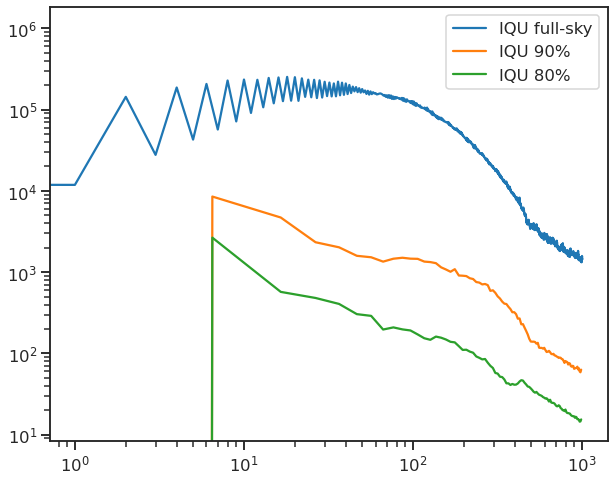

In [289]:
plt.figure(figsize = (10,8))
plt.loglog(ell_hp,  cl_norm_hp*cl2_hp['TT'], label = 'IQU full-sky')
# plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_hp['TT'], 'k--', label = 'IQU_ori full-sky')

plt.loglog(ell,  cl_norm*cl2_na_90['TT'], label = 'IQU 90%')
plt.loglog(ell,  cl_norm*cl2_na['TT'], label = 'IQU 80%')
# plt.loglog(ell,  cl_norm*cl_IQU_na['TT'], 'k--', label = 'IQU_ori 80%')

# plt.loglog(ell,  cl_norm*cl2_na_50['TT'], label = 'IQU 50%')

plt.legend()

Text(0.5, 0.98, 'Green: IQU; Red: IQU_iqu; 100%, 90%, 80%, 50%; Direction 1')

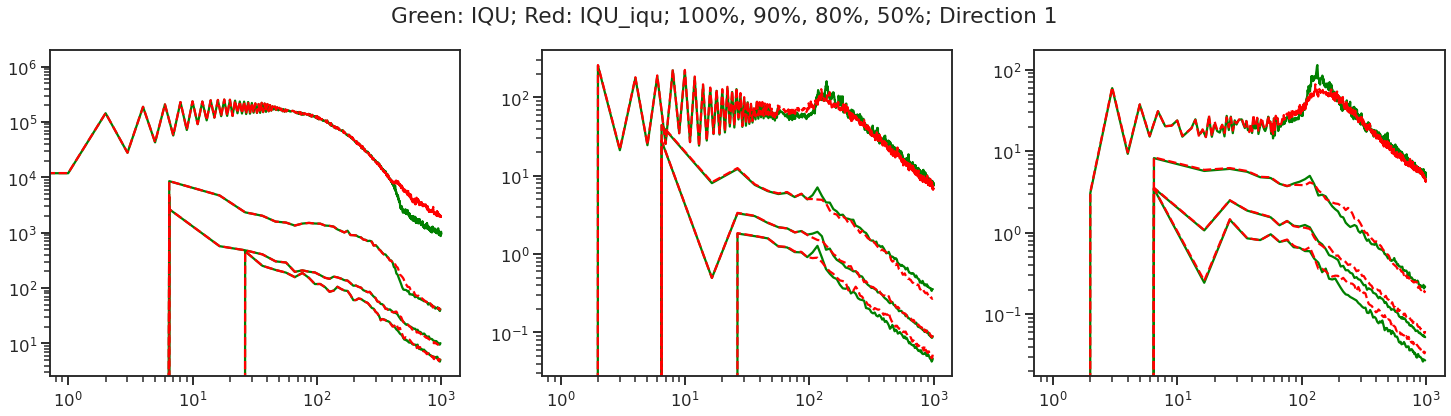

In [409]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl2_hp[modes[i]], 'g-', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl2_na_90[modes[i]], 'g-',label = '90%')
    ax.loglog(ell,  cl_norm*cl2_na[modes[i]], 'g-',label = '80%')
    ax.loglog(ell,  cl_norm*cl2_na_50[modes[i]], 'g-',label = '50%')
    
    # ax.loglog(ell,  cl_norm*cl_IQU_na[modes[i]], 'k--',label = '80%')
    
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_hp[modes[i]], 'r--', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_90[modes[i]], 'r--', label = '90%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na[modes[i]], 'r--', label = '80%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_50[modes[i]], 'r--', label = '50%')
fig.suptitle('Green: IQU; Red: IQU_iqu; 100%, 90%, 80%, 50%; Direction 1')

Text(0.5, 0.98, 'Green: IQU; Red: IQU_iqu; 100%, 90%, 80%, 50%; Direction 2')

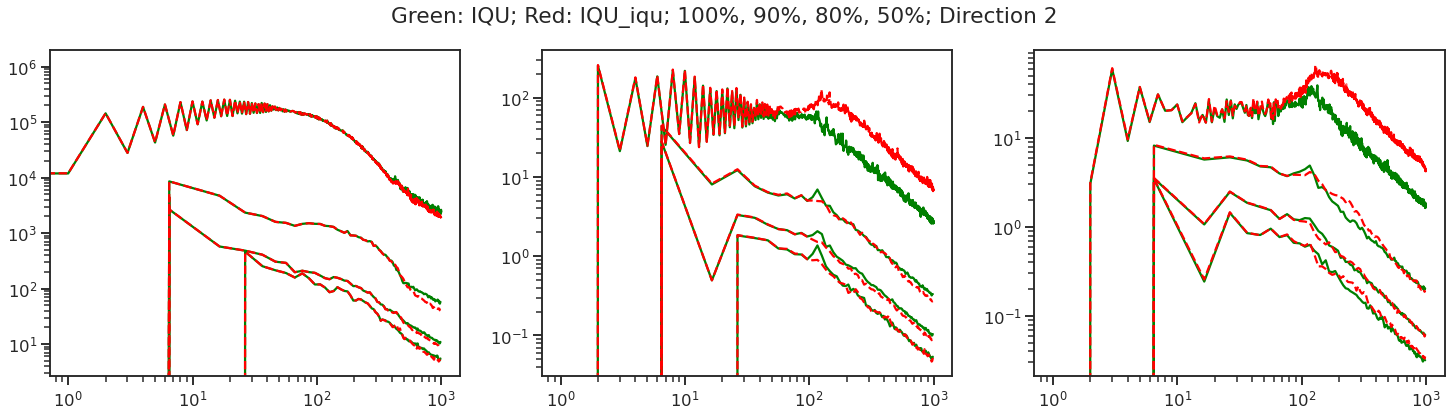

In [263]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl2_hp[modes[i]], 'g-', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl2_na_90[modes[i]], 'g-',label = '90%')
    ax.loglog(ell,  cl_norm*cl2_na[modes[i]], 'g-',label = '80%')
    ax.loglog(ell,  cl_norm*cl2_na_50[modes[i]], 'g-',label = '80%')
    
    # ax.loglog(ell,  cl_norm*cl_IQU_na[modes[i]], 'k--',label = '80%')
    
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_hp[modes[i]], 'r--', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_90[modes[i]], 'r--', label = '90%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na[modes[i]], 'r--', label = '80%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_na_50[modes[i]], 'r--', label = '80%')
fig.suptitle('Green: IQU; Red: IQU_iqu; 100%, 90%, 80%, 50%; Direction 2')

In [94]:
log_ss_mod = np.zeros_like(ss)
log_ss_mod[0] =log_ss[0]*modulate_amp
log_ss_mod[1:] = log_ss[1:]*modulate_amp_pol

log_map_out_mod = log_ls + log_ss_mod
IQU_log_map_out_mod = log_pol_tens_to_map(log_map_out_mod)

In [304]:
SS_log_ss_mod = log_pol_tens_to_map(log_ss_mod)

In [98]:
ell_hp, cl_norm_hp, cl_IQU_iqu_hp = run_anafast(IQU_log_map_out_mod, lmax = lmax)
ell, cl_norm, cl_IQU_iqu_na = run_namaster(IQU_log_map_out_mod, mask=planck_mask_80, lmax=lmax, nlbins = 10)
ell, cl_norm, cl_IQU_iqu_na_90 = run_namaster(IQU_log_map_out_mod, mask=planck_mask_90, lmax=lmax, nlbins = 10)
ell, cl_norm, cl_IQU_iqu_na_50 = run_namaster(IQU_log_map_out_mod, mask=mask_50, lmax=lmax, nlbins = 10)

In [291]:
SS_IQU = get_small_scales(Map2, lmax, spectra_components, ell_fit_high, output_nside)

In [99]:
ss_IQU_iqu = get_small_scales(IQU_log_map_out_mod, lmax, spectra_components, ell_fit_high, output_nside)

In [120]:
ell_hp, cl_norm_hp, cl_IQU_iqu_ss_hp = run_anafast(ss_IQU_iqu, lmax = lmax)
ell, cl_norm, cl_IQU_iqu_ss_na = run_namaster(ss_IQU_iqu, mask=planck_mask_80, lmax=lmax, nlbins = 10)
ell, cl_norm, cl_IQU_iqu_ss_na_90 = run_namaster(ss_IQU_iqu, mask=planck_mask_90, lmax=lmax, nlbins = 10)

In [121]:
ell_hp, cl_norm_hp, cl2_ss_hp = run_anafast(SS_IQU, lmax = lmax)
ell, cl_norm, cl2_ss_na = run_namaster(SS_IQU, mask=planck_mask_80, lmax=lmax, nlbins = 10)
ell, cl_norm, cl2_ss_na_90 = run_namaster(SS_IQU, mask=planck_mask_90, lmax=lmax, nlbins = 10)

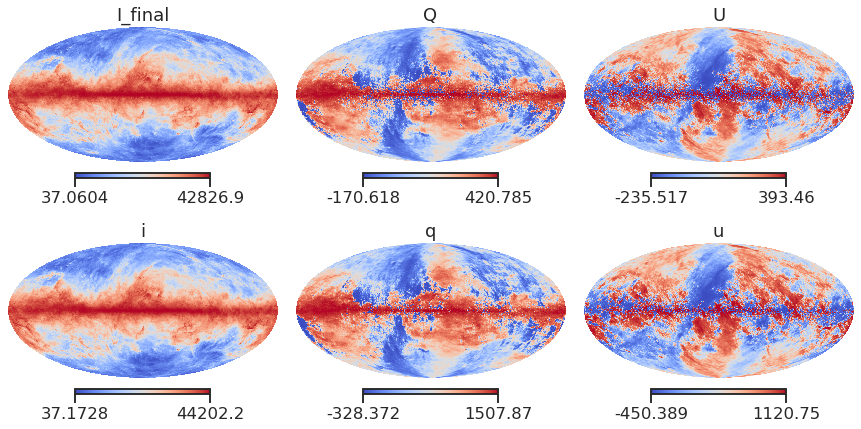

In [433]:
plot_comparision2(Map2, IQU_log_map_out_mod, title = 'final')

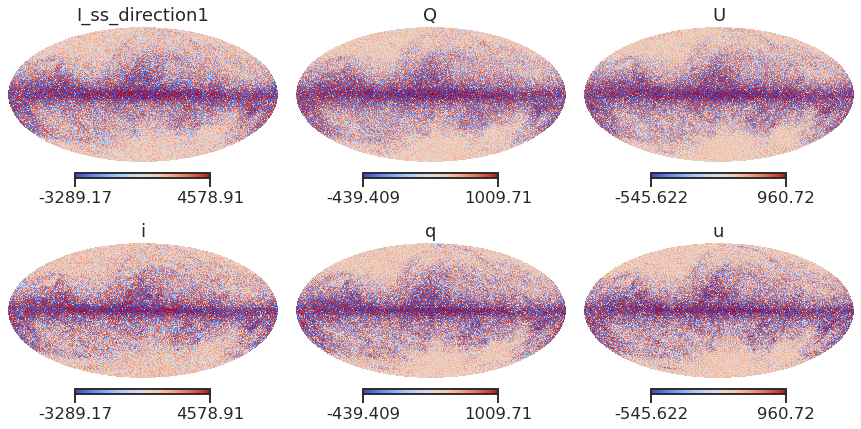

In [295]:
plot_comparision2(SS_IQU, ss_IQU_iqu, title = 'ss_direction1', I_lim = [-3289.17, 4578.91], Q_lim = [-439.409, 1009.71], U_lim = [-545.622, 960.72])

In [ ]:
hp.gnomview(ss_IQU_iqu[1] ,cmap='RdBu',   title='ss_IQU_iqu', rot=[0,lat],reso=3.75,xsize=320,  sub=222)

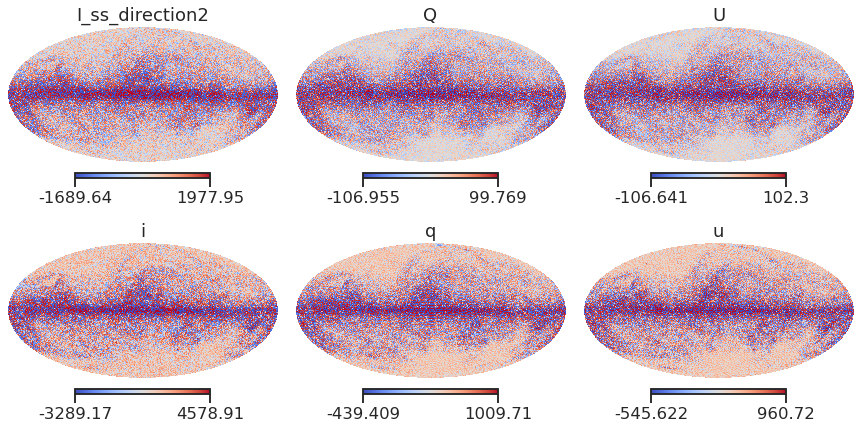

In [290]:
plot_comparision2(SS_IQU, ss_IQU_iqu, title = 'ss_direction2')

In [410]:
SS_mod = Map2 - ls
ss_mod = IQU_log_map_out_mod - ls 

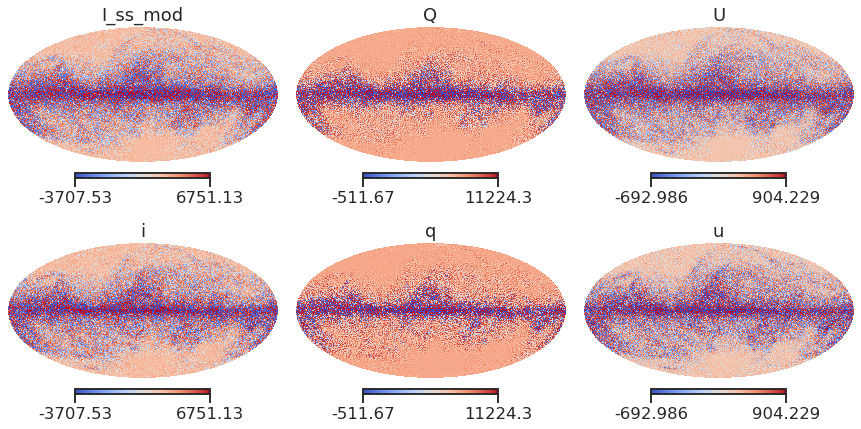

In [411]:
plot_comparision2(SS_mod, ss_mod, title="ss_mod", I_lim = [-3707.53, 6751.13], Q_lim = [-511.67, 11224.3], U_lim = [-692.986, 904.229])

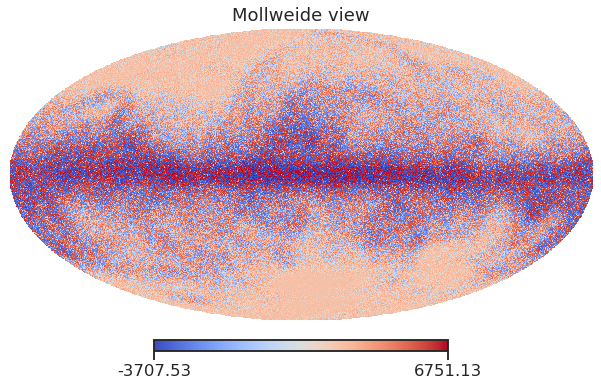

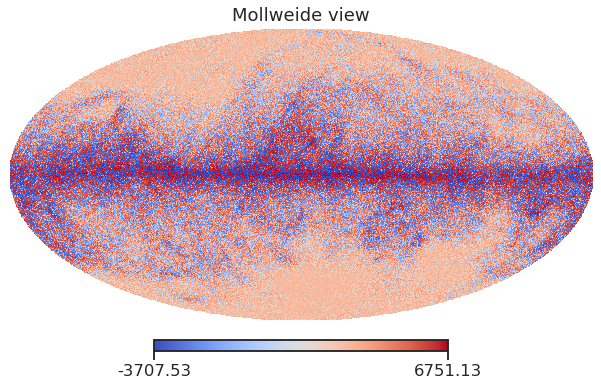

In [300]:
hp.mollview(SS_mod[0], norm = 'hist', min = -3707.53, max = 6751.13)
hp.mollview(ss_mod[0], norm = 'hist', min = -3707.53, max = 6751.13)

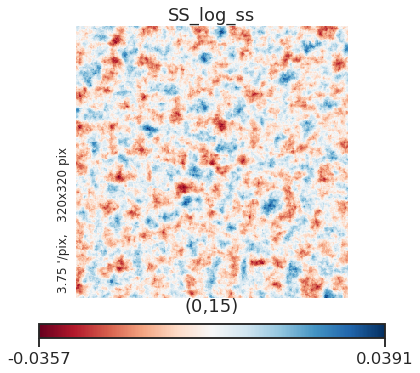

In [306]:
plt.figure(figsize=(20,10))
lat = 15
hp.gnomview(SS_log_ss_mod[1] ,cmap='RdBu',   title='SS_log_ss', rot=[0,lat],reso=3.75,xsize=320,  sub=221)

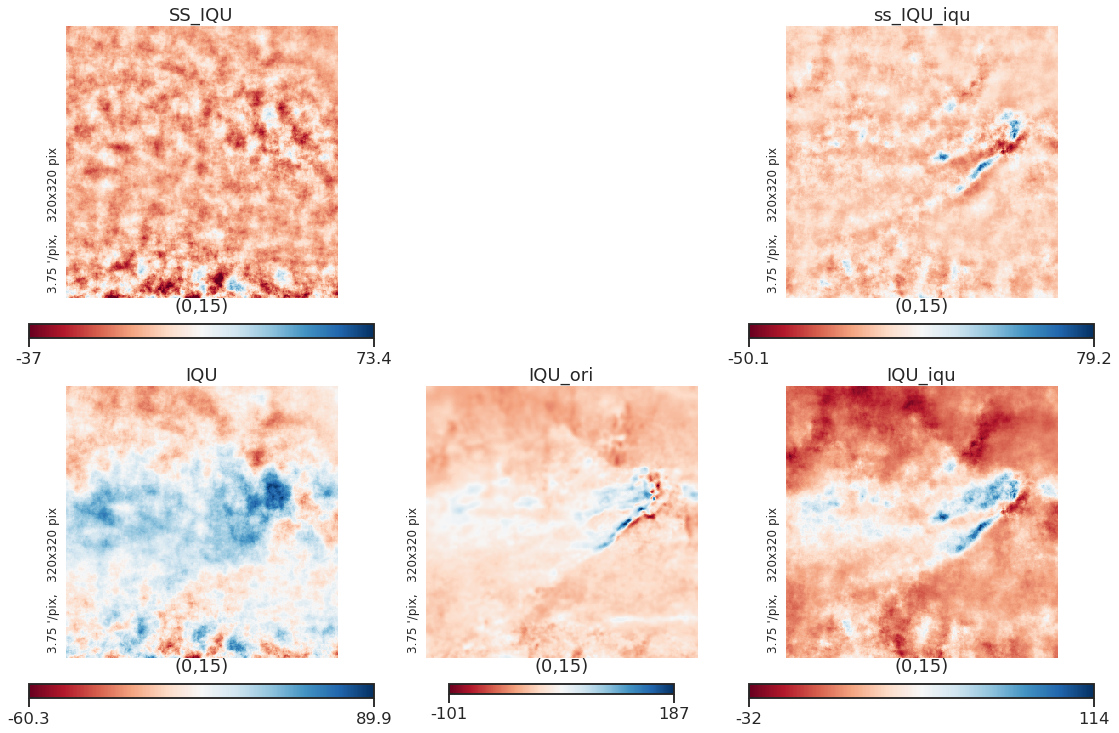

In [303]:
plt.figure(figsize=(20,10))
lat = 15
hp.gnomview(SS_mod[1] ,cmap='RdBu',   title='SS_IQU', rot=[0,lat],reso=3.75,xsize=320,  sub=221, min = -37, max = 73.4)
hp.gnomview(ss_mod[1] ,cmap='RdBu',   title='ss_IQU_iqu', rot=[0,lat],reso=3.75,xsize=320,  sub=222)
hp.gnomview(Map2[1] ,cmap='RdBu',   title='IQU', rot=[0,lat],reso=3.75,xsize=320,  sub=223)
hp.gnomview(IQU_log_map_out_mod[1] ,cmap='RdBu',   title='IQU_iqu', rot=[0,lat],reso=3.75,xsize=320,  sub=224)
hp.gnomview(dust_IQU[1] ,cmap='RdBu',   title='IQU_ori', rot=[0,lat],reso=3.75,xsize=320,  sub=235)

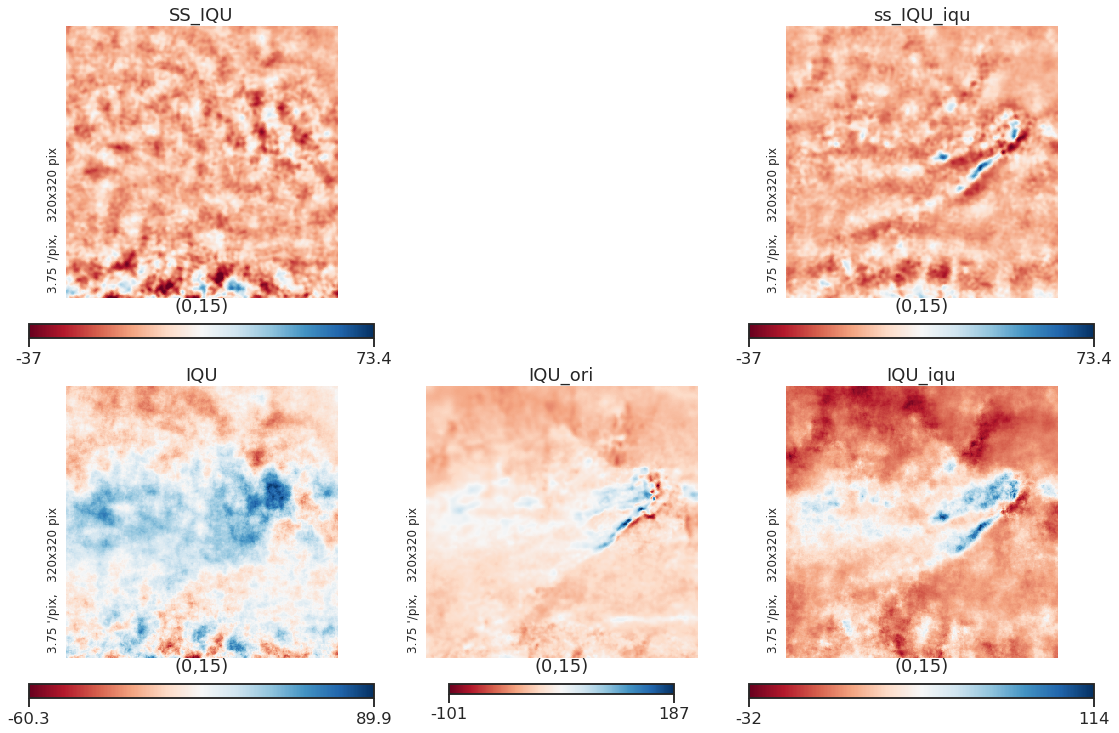

In [302]:
plt.figure(figsize=(20,10))
lat = 15
hp.gnomview(SS_IQU[1] ,cmap='RdBu',   title='SS_IQU', rot=[0,lat],reso=3.75,xsize=320,  sub=221, min = -37, max = 73.4)
hp.gnomview(ss_IQU_iqu[1] ,cmap='RdBu',   title='ss_IQU_iqu', rot=[0,lat],reso=3.75,xsize=320,  sub=222)
hp.gnomview(Map2[1] ,cmap='RdBu',   title='IQU', rot=[0,lat],reso=3.75,xsize=320,  sub=223)
hp.gnomview(IQU_log_map_out_mod[1] ,cmap='RdBu',   title='IQU_iqu', rot=[0,lat],reso=3.75,xsize=320,  sub=224)
hp.gnomview(dust_IQU[1] ,cmap='RdBu',   title='IQU_ori', rot=[0,lat],reso=3.75,xsize=320,  sub=235)


Text(0.5, 0.98, 'SS-Green: IQU; Red: IQU_iqu')

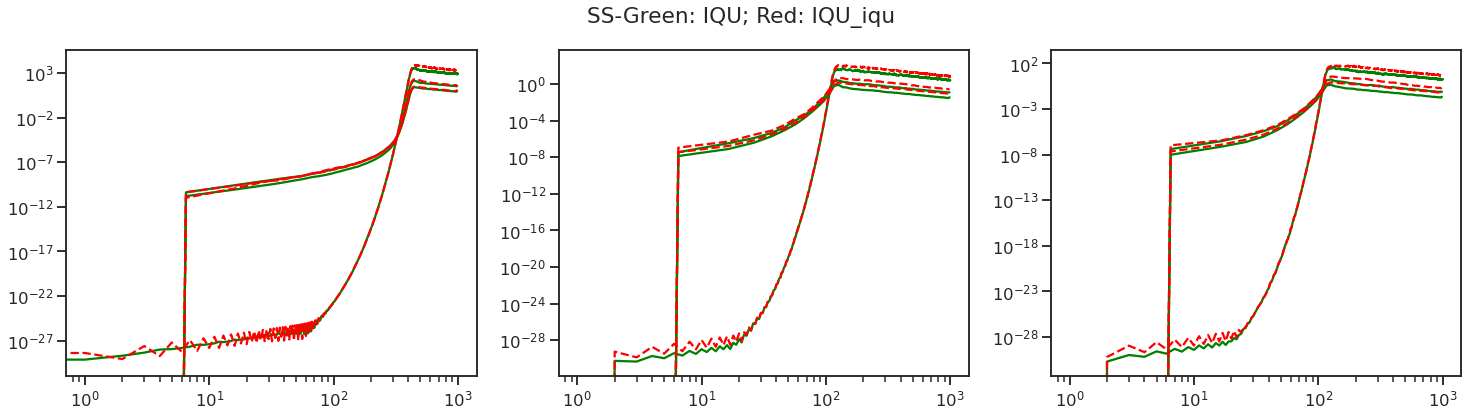

In [122]:
modes = ['TT', 'EE', 'BB']
fig, axes = plt.subplots(1,3, figsize=(25,6))
for i in range(3):
    ax = axes[i]
    ax.loglog(ell_hp,  cl_norm_hp*cl2_ss_hp[modes[i]], 'g-', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl2_ss_na_90[modes[i]], 'g-',label = '80%')
    ax.loglog(ell,  cl_norm*cl2_ss_na[modes[i]], 'g-',label = '80%')
    
    ax.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_ss_hp[modes[i]], 'r--', label = 'full-sky')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_ss_na_90[modes[i]], 'r--', label = '80%')
    ax.loglog(ell,  cl_norm*cl_IQU_iqu_ss_na[modes[i]], 'r--', label = '80%')
fig.suptitle('SS-Green: IQU; Red: IQU_iqu')

# test for iqu

In [44]:
ss_log_ss = log_pol_tens_to_map(log_ss)

In [45]:
ell_hp, cl_norm_hp, cl_ss_logss_hp = run_anafast(ss_log_ss[0], lmax = lmax)
ell, cl_norm, cl_ss_logss_na = run_namaster(ss_log_ss[0], mask=planck_mask_80, lmax=lmax, nlbins = 10)

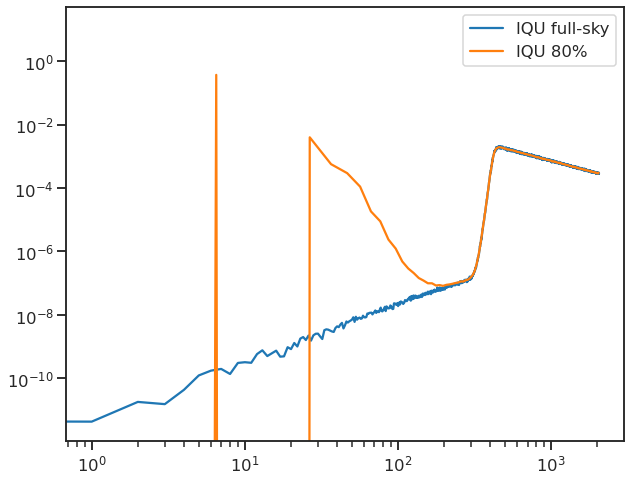

In [53]:
plt.figure(figsize = (10,8))
plt.loglog(ell_hp,  cl_norm_hp*cl_ss_logss_hp['TT'], label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_ss_logss_na['TT'], label = 'IQU 80%')
plt.legend()

In [34]:
log_ss_mod = np.zeros_like(ss)
log_ss_mod[0] =log_ss[0]*modulate_amp
log_ss_mod[1:] = log_ss[1:]*modulate_amp_pol

# ss_mod = np.zeros_like(ss)
# ss_mod[0] = ss[0]*(my_modulate_amp)
# ss_mod[1:] = ss[1:]*(my_modulate_amp_pol)  

# ss_log_ss_mod = log_pol_tens_to_map(log_ss_mod)

In [65]:
log_map_out = log_ls + log_ss
IQU_log_map_out = log_pol_tens_to_map(log_map_out)

map_out = ls + ss

In [59]:
map_out_go_iqu = log_pol_tens_to_map(fix_map(map_to_log_pol_tens(ls)) + fix_map(map_to_log_pol_tens(ss)))

/global/u2/j/jianyao/foreground_non_gaussianity/utilities.py:16: RuntimeWarning: invalid value encountered in log
  return img_resc, np.min(img), np.max(img)
/global/u2/j/jianyao/foreground_non_gaussianity/utilities.py:17: RuntimeWarning: invalid value encountered in log
  else:


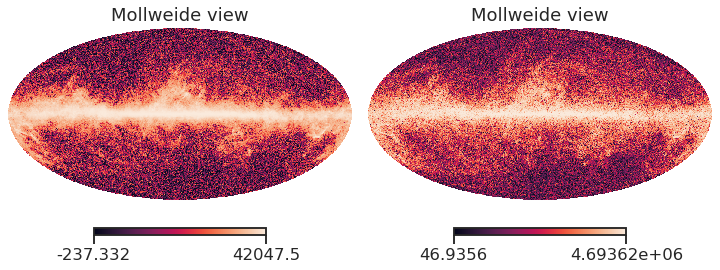

In [66]:
plt.figure(figsize = (10,8))
hp.mollview(map_out[0], norm = 'hist', sub = 121)
hp.mollview(map_out_go_iqu[0], norm = 'hist', sub = 122)

In [61]:
ell_hp, cl_norm_hp, cl_IQU_go_iqu_hp = run_anafast(map_out_go_iqu[0], lmax = lmax)
ell, cl_norm, cl_IQU_go_iqu_na = run_namaster(map_out_go_iqu[0], mask=planck_mask_80, lmax=lmax, nlbins = 10)

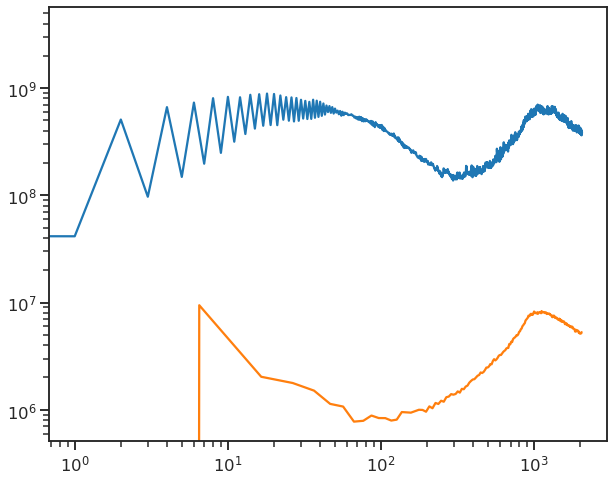

In [62]:
plt.figure(figsize = (10,8))
plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_go_iqu_hp['TT'], label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_IQU_go_iqu_na['TT'], label = 'IQU 80%')

In [35]:
log_map_out_mod = log_ls + log_ss_mod
IQU_log_map_out_mod = log_pol_tens_to_map(log_map_out_mod)

In [18]:
ell_hp, cl_norm_hp, cl_IQU_hp = run_anafast(map_out[0], lmax = lmax)
ell, cl_norm, cl_IQU_na = run_namaster(map_out[0], mask=planck_mask_80, lmax=lmax, nlbins = 10)

ell_hp, cl_norm_hp, cl_IQU_iqu_hp = run_anafast(IQU_log_map_out[0], lmax = lmax)
ell, cl_norm, cl_IQU_iqu_na = run_namaster(IQU_log_map_out[0], mask=planck_mask_80, lmax=lmax, nlbins = 10)

In [27]:
sta = time.time()
ell, cl_norm, cl_IQU_na_90 = run_namaster(map_out[0], mask=planck_mask_90, lmax=lmax, nlbins = 10)
end = time.time()
print((end-sta)/60)
ell, cl_norm, cl_IQU_iqu_na_90 = run_namaster(IQU_log_map_out[0], mask=planck_mask_90, lmax=lmax, nlbins = 10)
end2 = time.time()
print((end2-end)/60)

1.7385128577550253
1.7001165548960369


In [36]:
ell_hp, cl_norm_hp, cl_IQU_iqu_mod_hp = run_anafast(IQU_log_map_out_mod[0], lmax = lmax)
ell, cl_norm, cl_IQU_iqu_mod_na = run_namaster(IQU_log_map_out_mod[0], mask=planck_mask_80, lmax=lmax, nlbins = 10)

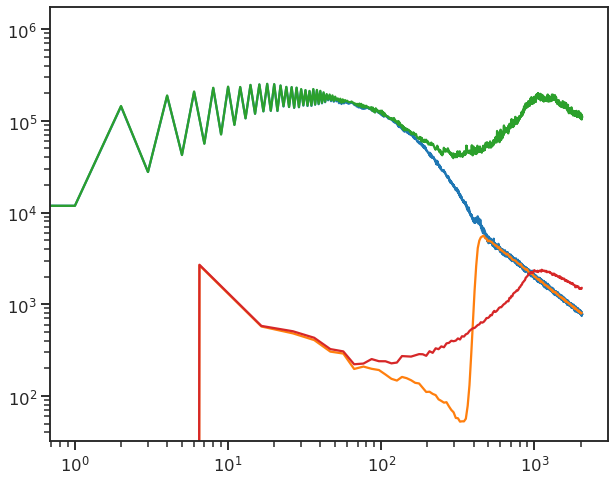

In [74]:
plt.figure(figsize = (10,8))
plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_hp['TT'], label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_IQU_na['TT'], label = 'IQU 80%')

plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_go_iqu_hp['TT']/1e3/3.5, label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_IQU_go_iqu_na['TT']/1e3/3.5, label = 'IQU 80%')

# plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_hp['TT'], label = 'IQU full-sky')
# plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_iqu_mod_hp['TT'], label = 'IQU full-sky')

# plt.loglog(ell,  cl_norm*cl_IQU_iqu_na['TT'], label = 'IQU 80%')
# plt.loglog(ell,  cl_norm*cl_IQU_iqu_mod_na['TT'], label = 'IQU 80%')


# plt.loglog(ell,  cl_norm*cl_IQU_na_90['TT'], label = 'IQU full-sky')
# plt.loglog(ell,  cl_norm*cl_IQU_iqu_na_90['TT'], label = 'IQU 80%')

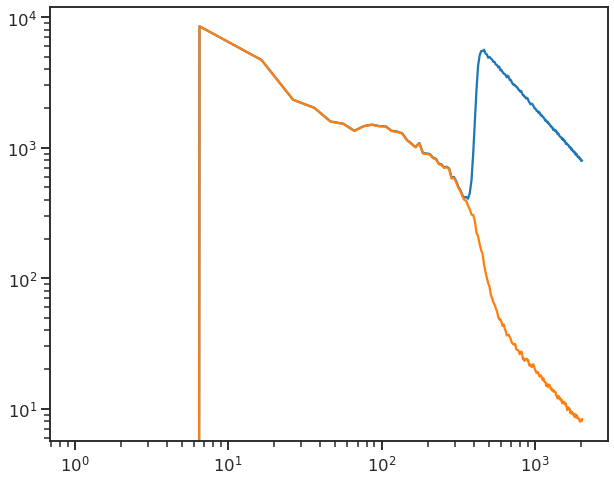

In [52]:
plt.figure(figsize = (10,8))

plt.loglog(ell,  cl_norm*cl_IQU_na_90['TT'], label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_IQU_iqu_na_90['TT'], label = 'IQU 80%')

In [58]:
def fix_map(maps):
    for i in range(3):
        maps[i, np.isnan(maps[i])] = np.nanmedian(maps[i])
    
    return maps

In [80]:
sky = pysm3.Sky(nside=2048, preset_strings=["d1"])
map_353 = sky.get_emission(353 * u.GHz)

/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/dust_t_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/dust_q_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/dust_u_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/dust_beta.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37:

In [81]:
ell_hp, cl_norm_hp, cl_pysm_hp = run_anafast(map_353[0], lmax = lmax)
ell, cl_norm, cl_pysm_na = run_namaster(map_353[0], mask= planck_mask_80, lmax=lmax, nlbins = 10)

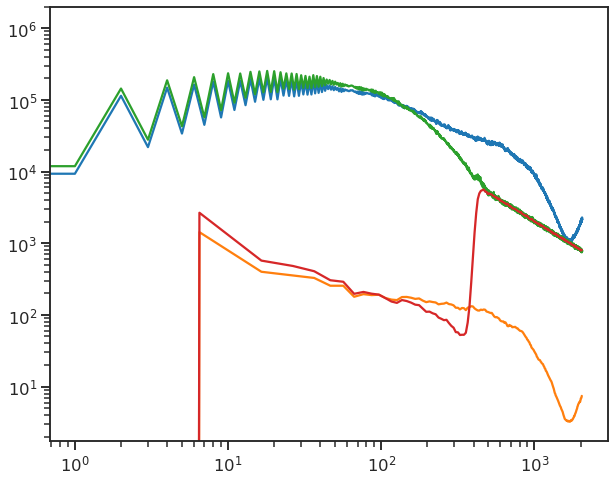

In [87]:
plt.figure(figsize = (10,8))

plt.loglog(ell_hp,  cl_norm_hp*cl_pysm_hp['TT'], label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_pysm_na['TT'], label = 'IQU 80%')

plt.loglog(ell_hp,  cl_norm_hp*cl_IQU_hp['TT'], label = 'IQU full-sky')
plt.loglog(ell,  cl_norm*cl_IQU_na['TT'], label = 'IQU 80%')

In [85]:
ell_hp.shape

(2049,)

# def

In [293]:
def plot_comparision2(IQU, iqu, I_lim = None, Q_lim = None, U_lim = None, title = 'ss'):
    
    plt.figure(figsize = (12, 6))
    if I_lim:
        hp.mollview(IQU[0], norm = 'hist', sub = 231, title = 'I_%s'%title, min = I_lim[0], max = I_lim[1])
        hp.mollview(IQU[1], norm = 'hist', sub = 232, title = 'Q', min = Q_lim[0], max = Q_lim[1])
        hp.mollview(IQU[2], norm = 'hist', sub = 233, title = 'U', min = U_lim[0], max = U_lim[1])

        hp.mollview(iqu[0], norm = 'hist', sub = 234, title = 'i', min = I_lim[0], max = I_lim[1])
        hp.mollview(iqu[1], norm = 'hist', sub = 235, title = 'q', min = Q_lim[0], max = Q_lim[1])
        hp.mollview(iqu[2], norm = 'hist', sub = 236, title = 'u', min = U_lim[0], max = U_lim[1])
    else:
        hp.mollview(IQU[0], norm = 'hist', sub = 231, title = 'I_%s'%title)
        hp.mollview(IQU[1], norm = 'hist', sub = 232, title = 'Q')
        hp.mollview(IQU[2], norm = 'hist', sub = 233, title = 'U')

        hp.mollview(iqu[0], norm = 'hist', sub = 234, title = 'i')
        hp.mollview(iqu[1], norm = 'hist', sub = 235, title = 'q')
        hp.mollview(iqu[2], norm = 'hist', sub = 236, title = 'u')

In [69]:
def difference(x):
    alpha = x[0];
    beta = x[1]
    Map2 = ls[0] + ss[0]*alpha*ls[0]**beta
    
    diff1 = np.mean(Map2) - np.mean(ls[0]);
    diff2 = np.std(Map2) - np.std(ls[0]);
    diff3 = skew(Map2) - skew(ls[0]);
    
    return diff1**2 + diff2**2 + diff3**2

minimize(difference, x0 = [0.5,1])